use default res: 0.005988023952095809 meter/pixel
xres: 0.005987261146496815
yres: 0.005982199665026147
The real pose of soanr is x:3.4700000286102295, y:-0.04999999701976776, z:2.000000238418579, roll:1.3281958103179932, pitch:0.02617993764579296, yaw:1.4974913597106934


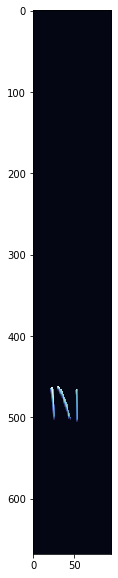

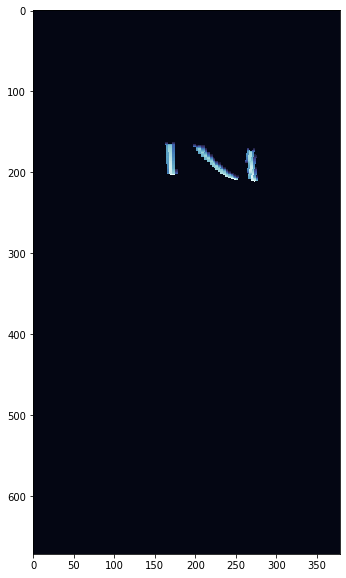

In [6]:
from procSonar import *
from skimage.io import imread
import matplotlib.pyplot as plt
import scipy.io as sio
import numpy as np
from angle_table import angle_table
from palettable.cmocean.sequential import Ice_20

### 设置参数
rmin = 0.7
rmax = 4.7
nbeams = 96  # ARIS 1800 High Freq
distance_resolution = 0.006
res = (rmax-rmin) / int(np.round((rmax-rmin) / distance_resolution))
r_of_cylinder = 0.025

### 显示图片的函数

### 读入 polar 图像
polar = imread('./fls/polar0.png', as_gray=True)
plt.figure(figsize=(10, 10))
plt.imshow(polar, cmap=Ice_20.mpl_colormap)

### 计算 LUT 并转换
LUT = computeLUT(rmin=rmin, rmax=rmax, angle_table=angle_table, res=None, img=polar)
carte = remap(polar, LUT)
plt.figure(figsize=(10, 10))
plt.imshow(carte, cmap=Ice_20.mpl_colormap)

### 读入 poses
pose = sio.loadmat('./fls/pose0.mat')
cam_xyz = pose['cam_xyz'][0]
cam_rpy = pose['cam_rpy'][0]
print("The real pose of soanr is x:{}, y:{}, z:{}, roll:{}, pitch:{}, yaw:{}"
      .format(cam_xyz[0], cam_xyz[1], cam_xyz[2], cam_rpy[0], cam_rpy[1], cam_rpy[2]))


In [7]:
###### 通过 Affinity Photo 手动得到端点的坐标，尝试是否能恢复出声呐的位姿
###### a b c -> left, center, right.
###### n f -> near, far
###### [beam, bin]
an = np.array([22, 463])
af = np.array([26, 499])
bn = np.array([30, 462])
bf = np.array([44, 500])
cn = np.array([53, 465])
cf = np.array([53, 503])

# Convert points in sonar img into 3D coordinates in the center of sonar
def polar2rect3D(theta, phi, r):
    x = r*np.cos(phi)*np.sin(theta)
    y = r*np.sin(phi)
    z = -r*np.cos(phi)*np.cos(theta)
    return np.array([x,y,z])

### 3D coords in sonar
an_xyz = polar2rect3D(angle_table.ac[an[0]], np.deg2rad(7), an[1]*res+rmin)
af_xyz = polar2rect3D(angle_table.ac[af[0]], np.deg2rad(-7), af[1]*res+rmin)
bn_xyz = polar2rect3D(angle_table.ac[bn[0]], np.deg2rad(7), bn[1]*res+rmin)
bf_xyz = polar2rect3D(angle_table.ac[bf[0]], np.deg2rad(-7), bf[1]*res+rmin)
cn_xyz = polar2rect3D(angle_table.ac[cn[0]], np.deg2rad(7), cn[1]*res+rmin)
cf_xyz = polar2rect3D(angle_table.ac[cf[0]], np.deg2rad(-7), cf[1]*res+rmin)

### real matrix
rROT = R.from_euler('xyz', cam_rpy).as_matrix()
rt = cam_xyz.reshape(-1, 1)  # [3, 1]



### Get 2x4 extended matrix
### R24 = [R11, R12, R13, tx]
###       [R21, R22, R23, ty]
pc = np.matrix([[an_xyz[0], af_xyz[0]]])
print('h')


h
